# Eurovision Turing Data Story

Authors: 
Ed Chapman, 
Katriona Goldmann, 
Radka Jersakova, 
David Llewellyn-Jones, 
Joe Palmer, 
Camila Rangel-Smith, 
Martin Stoffel
Jon Yong

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import seaborn as sns
sns.set_theme(style="whitegrid")

Load in the data and examine

In [133]:
df = pd.read_csv('../../data/df_main.csv')

df.head()

,year,Artist,from_country,to_country,points,total_points,rank,from_code2,from_code3,to_code2,...,Contains_Own_Language,gender,migration_v2p,population_p,prop_emigrants_v2p,migration_p2v,population_v,prop_emigrants_p2v,migration_pop_year,comps_since_last_win
0,1998,Danijela,belgium,croatia,5,131,5.0,BE,BEL,HR,...,True,female,205.0,4620030.0,0.000044,72.0,10136811.0,0.000007,1995.0,42
1,1998,Michael Hajiyanni,belgium,cyprus,2,37,11.0,BE,BEL,CY,...,True,male,92.0,862418.0,0.000107,77.0,10136811.0,0.000008,1995.0,42
2,1998,Koit Toome,belgium,estonia,0,36,12.0,BE,BEL,EE,...,True,male,0.0,1436634.0,0.000000,57.0,10136811.0,0.000006,1995.0,42
3,1998,Vlado Janevski,belgium,north macedonia,0,16,19.0,BE,BEL,MK,...,True,male,NaN,NaN,NaN,120.0,10136811.0,0.000012,1995.0,42
4,1998,Edea,belgium,finland,0,22,15.0,BE,BEL,FI,...,True,group,144.0,5107790.0,0.000028,1541.0,10136811.0,0.000152,1995.0,42


## The Best Performing Countries

Lets determine the winners each year

In [25]:
winners = df.loc[df['rank'] == 1, ['to_country', 'total_points', 'rank', 'to_code2', 'year']]
winners = winners.drop_duplicates()

winners

,to_country,total_points,rank,to_code2,year
10,israel,172,1.0,IL,1998
618,sweden,163,1.0,SE,1999
1109,denmark,195,1.0,DK,2000
1660,estonia,198,1.0,EE,2001
2176,latvia,176,1.0,LV,2002
2737,turkey,167,1.0,TR,2003
3362,ukraine,280,1.0,UA,2004
4188,greece,230,1.0,GR,2005
5098,finland,292,1.0,FI,2006
5998,serbia,268,1.0,RS,2007


The countries who have won multiple times in this time frame are:

In [26]:
winners['to_country'].value_counts().loc[winners['to_country'].value_counts() > 1]

ukraine    3
sweden     3
israel     2
denmark    2
Name: to_country, dtype: int64

In [55]:
# counties with the best average score per year
temp = df[['to_country', 'to_code2', 'total_points', 'year']].drop_duplicates()

temp.groupby('to_country')['total_points'].mean().sort_values(ascending=False).index[:4]


Index(['yugoslavia', 'italy', 'bulgaria', 'ukraine'], dtype='object', name='to_country')

In [113]:
my_cmap = plt.get_cmap("magma_r")
rescale = lambda y: (y) / (26)


def plot_country(code, ax, df_plot):
    df_temp = df_plot.loc[df_plot['to_code2'] == code]

    df_temp = df_temp.sort_values('year', ascending=False)    

    country_name = df_temp['to_country'].iloc[0].title()

    # for year in 1997 - 2022 not in df_temp['year'] add a row
    for i in range(1997, 2022):
        if (i not in df_temp['year'].values):
            df_add = pd.DataFrame(dict(year= i, total_points= np.nan, 
                        rank= np.nan, to_code2= code, to_country= country_name), 
                        index=[0])
            df_temp = pd.concat([df_temp, df_add], ignore_index=True)

    ax.bar(df_temp['year'], df_temp['total_points'], 
            color=my_cmap(rescale(df_temp['rank'])))

    ax.scatter(2020, 10, s=25, color='grey', marker="_")

    # annotate if nan (did not perform)
    for i, v in enumerate(df_temp.loc[df_temp['year'] != 2020, 'total_points']):
        if np.isnan(v):
            ax.scatter(df_temp['year'].iloc[i], 10, s=25, color='grey', marker="x")


    winner = df_temp.loc[df_temp['rank'] == 1, ['year', 'total_points']]
    winner = winner.drop_duplicates()
    if winner.shape[0] > 0:
        ax.scatter(winner['year'], winner['total_points'], s=50, 
                    color='gold', marker="*", edgecolor='black', zorder=5)

    ax.set_xlim(1997, 2023)
    ax.set_title(country_name)


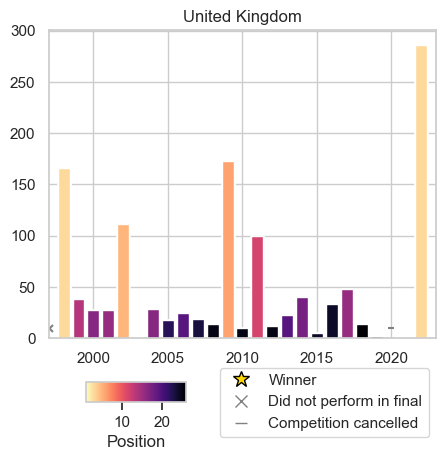

In [130]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), sharey=True, sharex=True, squeeze=True)

plot_country('GB', ax, df)

legend_elements = [Line2D([0], [0], marker='*', color='white', label='Winner',
                          markerfacecolor='gold', markersize=12, markeredgecolor='black'),                          
                  Line2D([0], [0], marker='x', color='white', label='Did not perform in final',
                          markerfacecolor='grey', markersize=8, markeredgecolor='grey'), 
                  Line2D([0], [0], marker='_', color='white', label='Competition cancelled',
                          markerfacecolor='grey', markersize=8, markeredgecolor='grey')]
fig.legend(handles=legend_elements, loc='right', ncol=1, bbox_to_anchor=(0.9, -0.05))

sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=1, vmax=26))
cbaxes = fig.add_axes([0.2, -0.05, 0.2, 0.05]) # x y deltax deltay

fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1, label='Position', 
             cax = cbaxes)

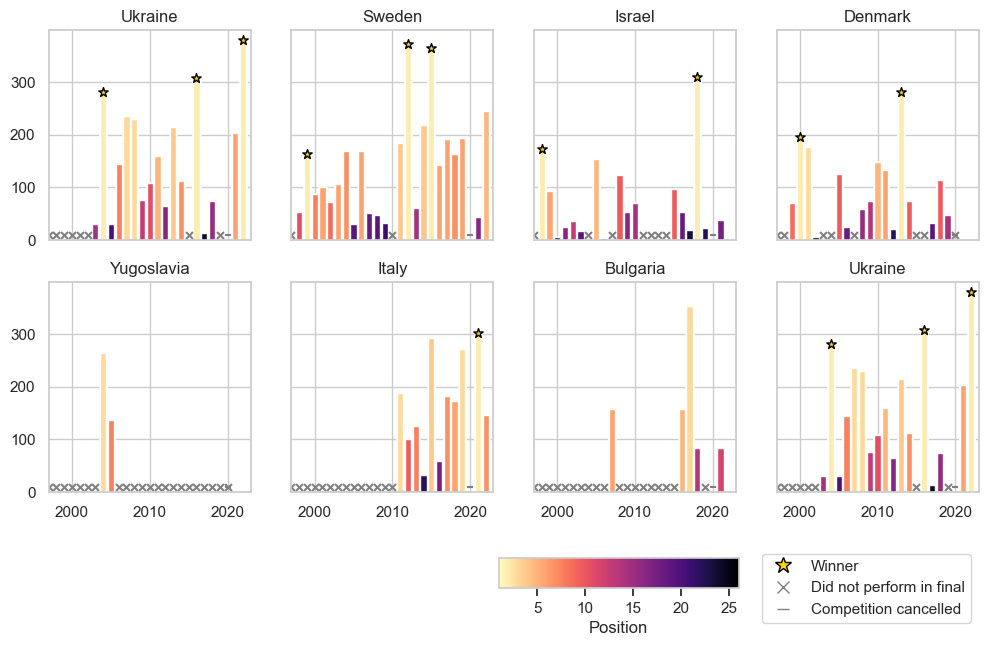

In [132]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True, squeeze=True)

plot_countries = winners['to_code2'].value_counts().loc[winners['to_code2'].value_counts() > 1].index
for i in range(len(plot_countries)): 
    plot_country(plot_countries[i], ax[0, i], df)

plot_countries = temp.groupby('to_code2')['total_points'].mean().sort_values(ascending=False).index[:4]
for i in range(len(plot_countries)): 
    plot_country(plot_countries[i], ax[1, i], df)

fig.legend(handles=legend_elements, loc='right', ncol=1, bbox_to_anchor=(0.9, -0.05))

sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=1, vmax=26))
cbaxes = fig.add_axes([0.5, -0.05, 0.2, 0.05]) # x y deltax deltay

fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1, label='Position', 
             cax = cbaxes)


## Voting Deviations Between Countries